In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import seaborn as sns
from matplotlib import pyplot as plt
from utils import plot_topic_volume
import matplotlib.dates as md
from src.colnames import topic_col

%load_ext autoreload
%autoreload 2

### Extract best model

In [2]:
fit_on = 'eucomm'
eval_on = 'all'
MODEL_PATH = Path('logs') / 'topic' / fit_on / 'performances.jsonl'
models = pd.read_json(MODEL_PATH, orient='records', lines=True)

In [3]:
# models[models['name']==BEST_MODEL].sort_values(by='npmi_10', ascending=False)

In [4]:
best = models[(models['split']=='test') & (models['entity']==eval_on)].sort_values(by='npmi_10', ascending=False)
BEST_MODEL = best.name.tolist()[0]
BEST_RUN = best.run.tolist()[0]
BEST_PATH = Path('models') / 'topic' / fit_on / BEST_MODEL / f'run-{BEST_RUN}' / 'model.json'
PRED_PATH = Path('logs') / 'topic' / fit_on / BEST_MODEL / f'run-{BEST_RUN}' / 'preds.jsonl'
topics = json.load(open(BEST_PATH))
preds = pd.read_json(PRED_PATH, orient='records', lines=True)
preds['top_topic'] = np.argmax(preds[[f'topic_{i}' for i in range(20)]].values, axis=1)
preds['top_topic'] = preds['top_topic'].apply(lambda x: f'topic_{str(x)}')
preds['confidence'] = np.max(preds[[f'topic_{i}' for i in range(20)]].values, axis=1)

In [5]:
topic_col

['humanitarian_support_and_refugees',
 'health',
 'citizens_engagement_and_culture',
 'press_conferences_and_statements',
 'citizens_rights_and_regulations',
 'charts_links_and_infographics',
 'investments_recovery_growth_and_innovation',
 'governance_and_international_relations',
 'sustainability_energy_and_climate',
 'identity_and_culture',
 'vision_for_the_future',
 'humanitarian_financial_aid',
 'human_rights',
 'global_goals',
 'economy_and_markets',
 'digital_policy',
 'eu_policies_and_partnerships',
 'live_events',
 'digital_and_green_transition',
 'finance_and_trade']

In [6]:
topic_n = 9
preds['top_diff'] = preds['topic_0'] - preds['topic_11']
preds['top_rev'] = preds['topic_11'] - preds['topic_0']
print(topic_col[topic_n])
for i,k in enumerate(preds.sort_values(by='top_rev', # f'topic_{topic_n}', 
                                       ascending=False).head(n=20).text.tolist()):
    print(f'{i+1}. {k}\n')

identity_and_culture
1. Syria Emergency Response Fund has allocated $31.6M for 100 projects in Syria, Iraq, Jordan & Lebanon 

2. #Syria: 2.5 million ppl need #humanitarian assistance -- help by supporting the @unocha Emergency Response Fund 

3. Over 79,000 grants worth £18.8m have been provided to those in need through the Scottish Welfare Fund 

4. .@UNCERF allocated over $6 million to assist humanitarian partners in the fight against #Ebola 

5. €5 million in humanitarian aid for the Burundian crisis 

6. Syria: critical funding shortage threatens humanitarian response 

7. #Libya: #UN revises appeal for humanitarian assistance to more than $400 million 

8. Haiti Flash Appeal: $119M urgently needed to provide immediate life-saving aid to 750,000 people 

9. #Syria: Humanitarian appeal raised to $347 million to help growing number of Syrians in need 

10. UN and partners seek $36 million to aid Madagascar amid multiple crises: 

11. Additional €20 million to support Jordan in #Syri

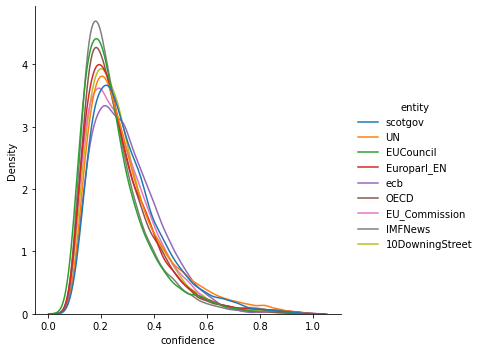

In [7]:
sns.displot(data=preds, x='confidence', hue='entity', kind='kde', common_norm=False)
plt.show()

After inspection of topics, we labeled them in `src.colnames` as `topic_col`

In [8]:
from src.colnames import topic_col
mapping = dict(zip([f'topic_{n}' for n in range(20)], 
                    topic_col))
preds_long = pd.melt(preds, id_vars='entity', value_vars=mapping.keys()).replace(mapping)

In [9]:
avg = preds_long.groupby(['entity', 'variable']).mean().reset_index()

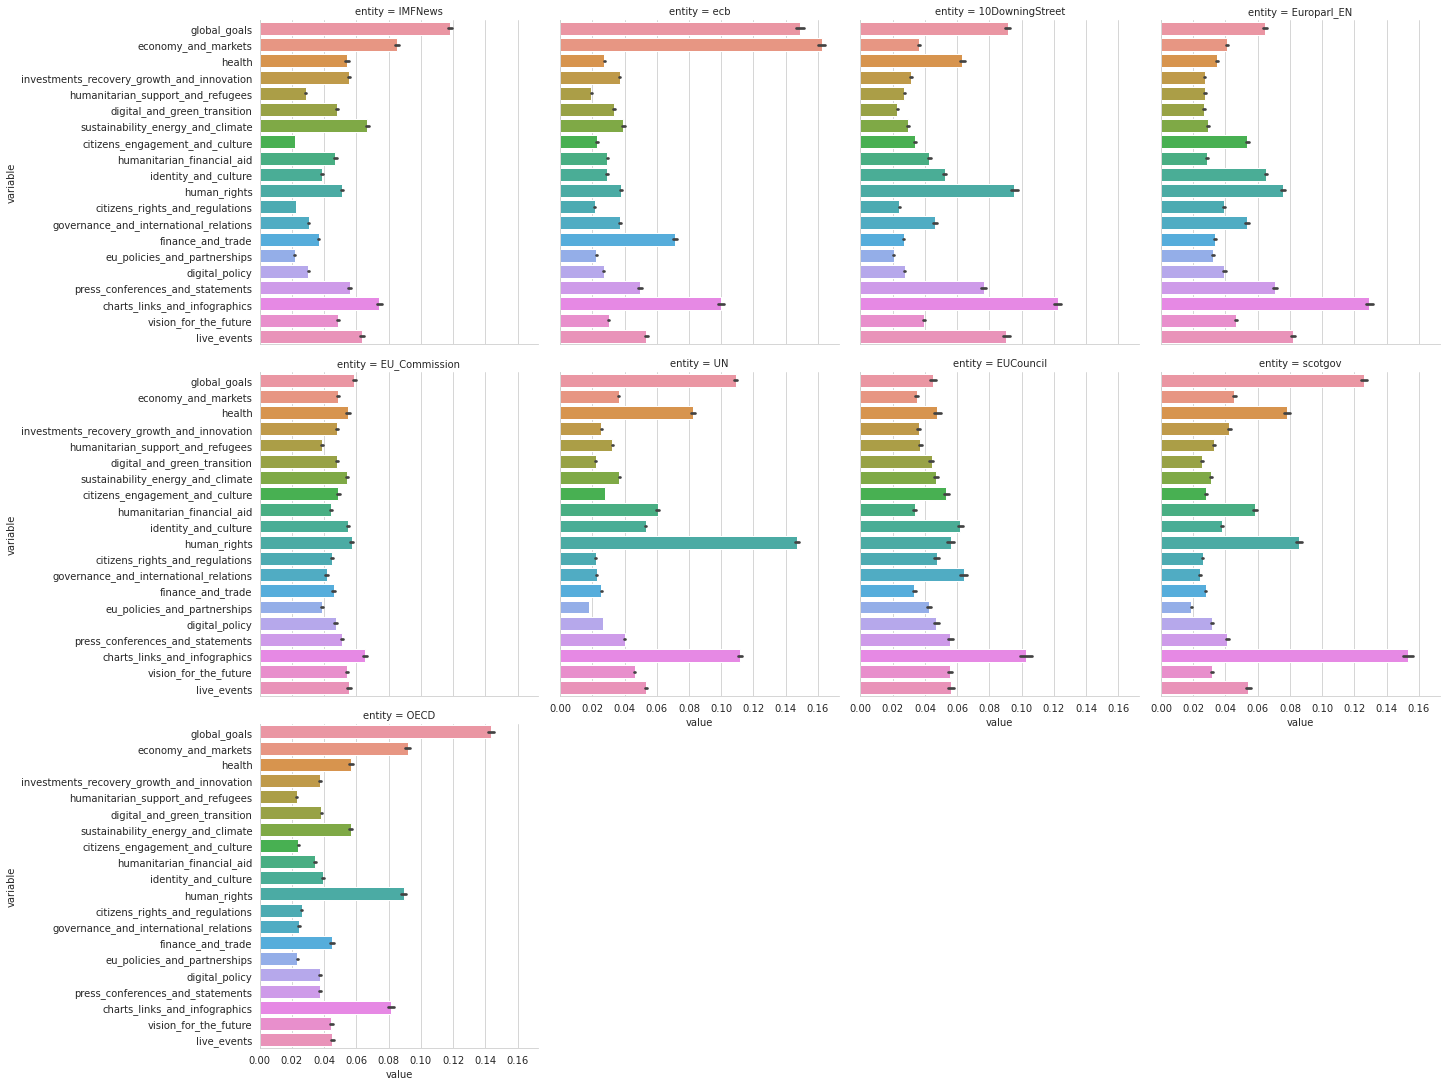

In [10]:
sns.set_style('whitegrid')
sns.catplot(data=preds_long.sort_values(by='value'),
            col='entity', x='value', y='variable', kind='bar', col_wrap=4)

In [11]:
preds.rename(mapping, axis=1).iloc[:,1:].to_json('data/topic/data.jsonl', 
                                                 orient='records', 
                                                 lines=True)

### Topics over time


In [12]:
from collections import defaultdict
new_names = ['Economy and markets', 'Finance and trade',
             'Strategic investments', 
             'Health',
             "Citizens’ rights and EU rules", 'Digital policy',
             'Digital and green transition', 'Energy and sustainability',
             'Identity and culture', 'Future of Europe',
             'Citizen engagement', 'Governance and international relations',
             'EC policy and partnerships', 
             'Humanitarian support (general)', 'Humanitarian support (financial)',
             'Human rights', 'Growth and Global Development', 
             'Press conferences and statements',
             'Charts, links, infographics', 'Live events']
old_names = ['economy_and_markets', 'finance_and_trade',
             'investments_recovery_growth_and_innovation', 'health',
             'citizens_rights_and_regulations', 'digital_policy',
             'digital_and_green_transition', 'sustainability_energy_and_climate',
             'identity_and_culture', 'vision_for_the_future',
             'citizens_engagement_and_culture', 
             'governance_and_international_relations',
             'eu_policies_and_partnerships', 
             'humanitarian_support_and_refugees', 
             'humanitarian_financial_aid', 
             'human_rights', 'global_goals', 
             'press_conferences_and_statements', 
             'charts_links_and_infographics', 
             'live_events']
categories = ['Economy and Finance'] * 3 + \
             ['Policy and integration'] * 5 + \
             ['Identity and Culture'] * 3 + \
             ['Governance and partnerships'] * 2 + \
             ['Humanitarian'] * 3 + ['Economy and Finance'] + \
             ['Miscellaneous'] * 3

new_to_old = dict(zip(new_names, old_names))
old_to_new = dict(zip(old_names, new_names))
new_to_cat = dict(zip(new_names, categories))
cats = defaultdict(list)
for i,c in enumerate(categories):
    cats[c].append(new_names[i])

In [13]:
for k,v in cats.items():
    preds[k] = preds.rename(mapping, axis=1)[[new_to_old[old] for old in v]].mean(axis=1)

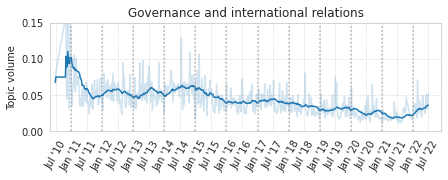

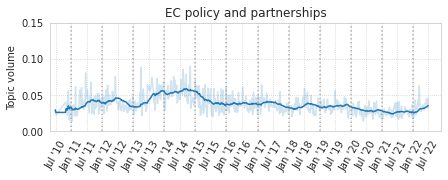

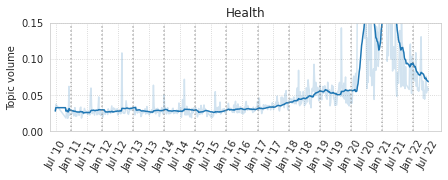

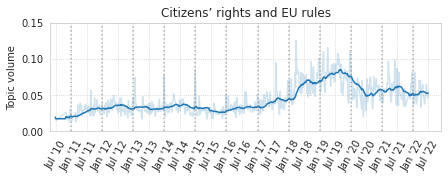

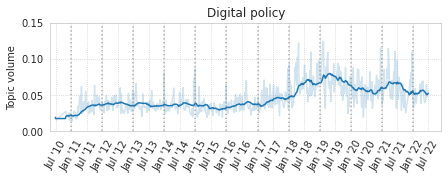

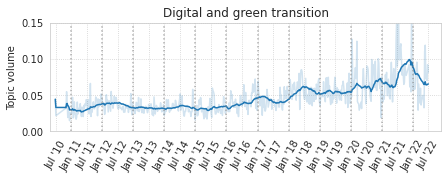

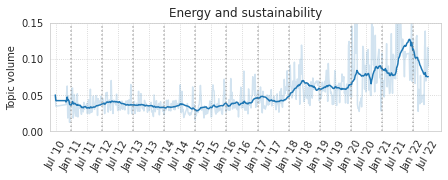

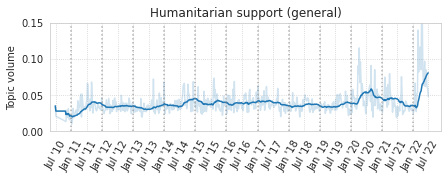

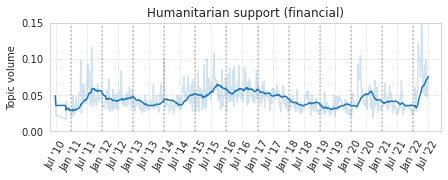

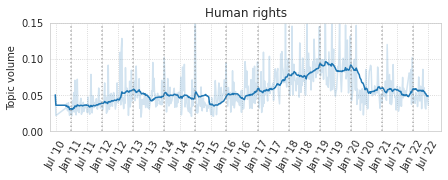

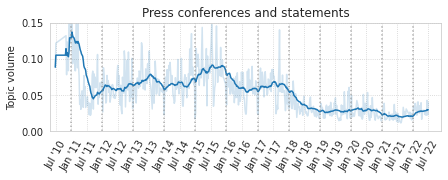

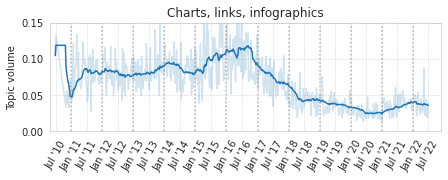

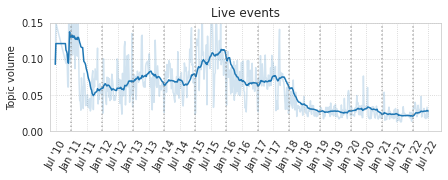

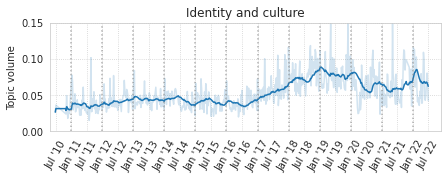

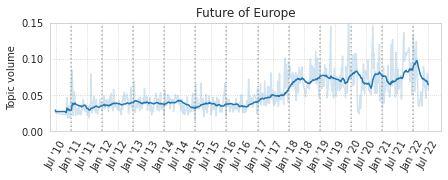

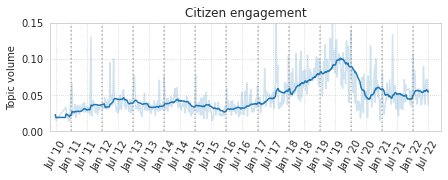

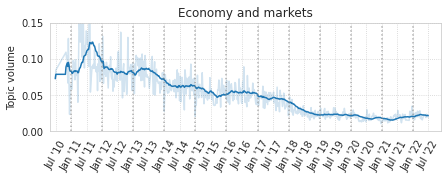

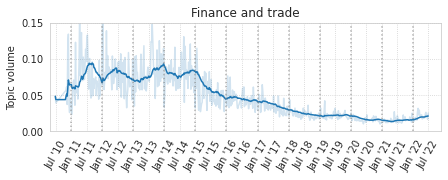

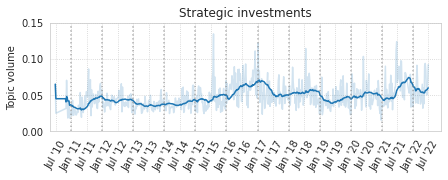

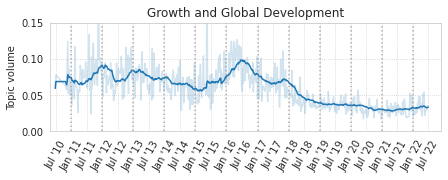

In [14]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
for t in set(categories): #:
    for k in cats[t]:
        plot_topic_volume(preds.rename(mapping, axis=1), 
                          entity='EU_Commission',
                          topics=old_names, # mapping.values() 
                          freq='W', roll_window=24,
                          savename='topic_volume', interactive=False,
                          exclude_topics=set(old_names) - set([new_to_old[k]]),  # mapping.values()
                          title=k,
                          figsize=(7,2), 
                          plot_smooth_only=False)

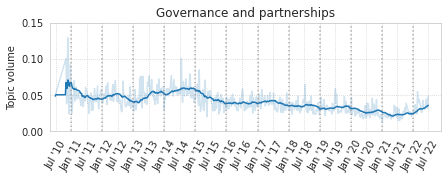

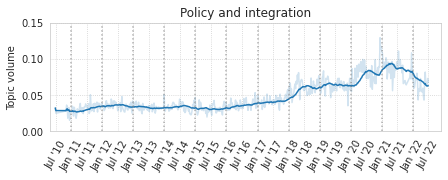

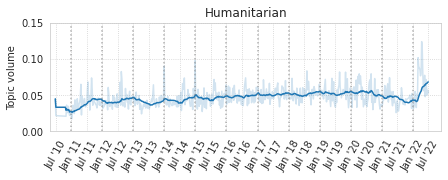

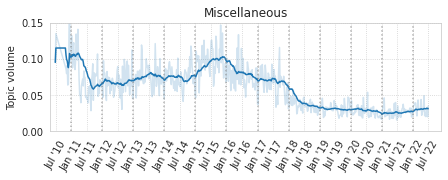

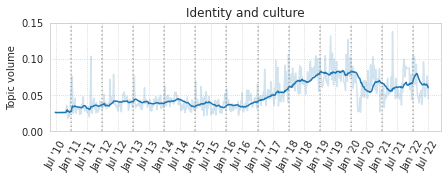

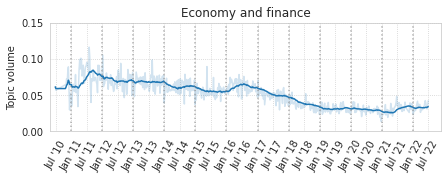

In [15]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
for t in set(categories):
    plot_topic_volume(preds,
                      entity='EU_Commission',
                      topics=categories,
                      freq='W', roll_window=24,
                      savename='topic_volume', interactive=False,
                      exclude_topics=set(categories) - set([t]),
                      title=t.replace('_', ' ').capitalize(),
                      figsize=(7,2), 
                      plot_smooth_only=False)

In [16]:
aggs = preds[preds['entity']=='EU_Commission'].rename(mapping, 
                                                      axis=1)[old_names].mean().T.reset_index()
aggs['group'] = aggs['index'].apply(lambda x: new_to_cat[old_to_new[x]])
aggs.columns = ['name', 'value', 'group']
aggs = aggs.sort_values(by=['value'], ascending=True)
aggs['name'] = aggs['name'].replace(old_to_new)

In [17]:
preds.groupby('top_topic').confidence.mean().reset_index().sort_values(by='confidence').replace(mapping)

,top_topic,confidence
10,digital_and_green_transition,0.210548
2,vision_for_the_future,0.215616
19,identity_and_culture,0.221038
8,eu_policies_and_partnerships,0.227399
0,humanitarian_support_and_refugees,0.235612
16,investments_recovery_growth_and_innovation,0.239404
14,citizens_rights_and_regulations,0.240006
18,sustainability_energy_and_climate,0.242330
13,press_conferences_and_statements,0.244997
7,digital_policy,0.251461


In [18]:
dd = preds.replace(mapping).rename(mapping, axis=1)
dd[dd['top_topic']=='investments_recovery_growth_and_innovation'].sort_values(by='investments_recovery_growth_and_innovation',ascending=False).head(n=30).text.tolist()

['€8.1 billion investment in research and innovation to create growth and jobs ',
 '€8.1 billion investment in research and #innovation to create growth and jobs  ',
 'Horizon 2020: Commission proposes €80 billion investment in research and innovation, to boost growth and jobs  ',
 "We welcome @EUCouncil's approval of the Recovery and Resilience Plan for Bulgaria.\n\nThis approval paves the way for disbursements of €6.3 billion to Bulgaria to foster its green transition and economic recovery from the COVID-19 pandemic. ",
 'The €672.5 billion in the Recovery and Resilience Facility will support key policies such as the green transition, digital transformation, crisis preparedness as well as support for young people → ',
 'European Fund for Strategic Investments is set to trigger investments of €251bn across Europe, after @EIB approved additional €1.8bn financing ',
 'Did you know around 967,000 SMEs are set to benefit from #investEU funds?\nThe Investment Plan is expected to trigger €4

In [19]:
preds['year'] = preds['created_at'].apply(lambda x: x.year)
preds['month'] = preds['created_at'].apply(lambda x: x.month)
preds['day'] = preds['created_at'].apply(lambda x: x.day)

In [20]:
counts = preds.rename(mapping, axis=1)[preds['entity']=='EU_Commission'].groupby(['top_topic', 'year'])['text'].agg(lambda x: x.count()).reset_index()
overall = preds.rename(mapping, axis=1)[preds['entity']=='EU_Commission'].groupby(['year'])['text'].agg(lambda x: x.count()).reset_index()

In [21]:
overall = overall.rename({'text': 'ov'}, axis=1)
counts = counts.merge(overall)
counts['text'] = counts['text']/counts['ov']

In [22]:
counts['top_topic'] = counts['top_topic'].apply(lambda x: old_to_new[mapping[x]])
counts = counts.sort_values(by='text')
counts['group'] = counts['top_topic'].replace(new_to_cat)

In [23]:
no = []
for k in cats.values():
    no += k

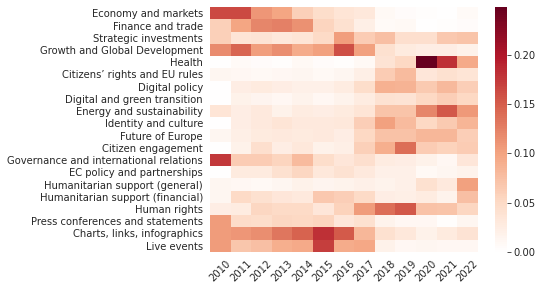

In [24]:
wide = pd.pivot(counts, 
                index='top_topic', 
                columns='year', 
                values='text').fillna(0)
#wide = ((wide-wide.mean())/wide.std()).T
wide = wide.T[no].T
plt.subplots(figsize=(6,4.5))
sns.heatmap(wide, 
            cmap='RdGy_r', 
            center=0)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.show()

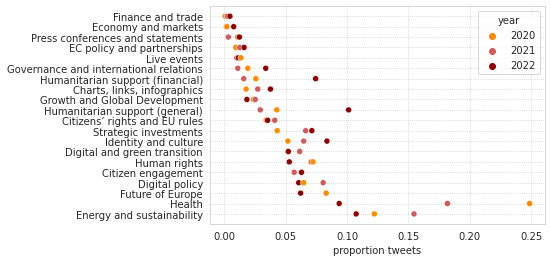

In [25]:
sns.scatterplot(data=counts[counts['year']>=2020].sort_values(by='text'),
                y='top_topic', x='text', hue='year', palette=['darkorange', 
                                                              'indianred',
                                                              'darkred'])
plt.xlabel('proportion tweets')
plt.ylabel('')
plt.show()

### Similarity with other agencies, over time

In [26]:
preds['year'] = preds['created_at'].apply(lambda x: x.year)
preds['month'] = preds['created_at'].apply(lambda x: x.month)
preds['day'] = preds['created_at'].apply(lambda x: x.day)

In [27]:
targs = list(mapping.keys())
sub = preds.groupby(['year', 'month', 'entity'])[targs].mean().reset_index() # 

In [28]:
import itertools
from scipy.stats import spearmanr
entities = list(itertools.combinations(preds.entity.unique(), 2))
cors = []
for year in preds.year.unique():
    #for month in preds.month.unique():
    for e0, e1 in entities:
        if e0 == 'EU_Commission' or e1 == 'EU_Commission':
            s1 = sub[(sub['year']==year) & (sub['entity']==e0)][targs].values
            s2 = sub[(sub['year']==year) & (sub['entity']==e1)][targs].values # (sub['month']==month) & 
            if len(s1) > 0 and len(s2) > 0:  #(sub['month']==month) & 
                c = spearmanr(s1[0],s2[0]).correlation
                if e0 == 'EU_Commission':
                    cors.append((year, e1, c)) #  
                else:
                    cors.append((year, e0, c)) # month,  

In [29]:
cor_df = pd.DataFrame(cors, columns=['year', 'entity', 'cor']) # 'month', 
cor_df['date'] = pd.to_datetime(cor_df[['year']].assign(month=1, day=1)).dt.strftime('%b \'%y') # , 'month'

In [30]:
vals = pd.to_datetime(cor_df[['year']].assign(month=1, day=1)).sort_values().dt.strftime('%b \'%y').unique() # , 'month'
dct = dict(zip(vals, range(vals.shape[0])))
cor_df['date_mapped'] = cor_df['date'].replace(dct)

In [31]:
inv_dct = dict(zip(dct.values(), dct.keys()))

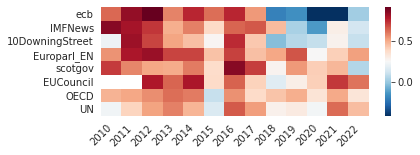

In [32]:
cc = cor_df.pivot(index='entity', columns='date_mapped', values='cor')
# cc = ((cc-cc.mean())/cc.std()).T
cc = cc.T[['UN', 'OECD', 'EUCouncil', 'scotgov', 'Europarl_EN', 
         '10DowningStreet', 'IMFNews', 'ecb'][::-1]]
cc = cc.T

plt.subplots(figsize=(6,2))
ax = sns.heatmap(cc, 
            cmap='RdBu_r', 
            #center=0,
            #vmin=-.3, vmax=.8
                )
plt.xlabel('')
plt.ylabel('')
plt.xticks(ticks=np.arange(0,13,1),
           labels=[f'20{inv_dct[k][5:]}' for k in np.arange(0,13,1)],
           rotation=45)
#plt.xticks(ticks=np.arange(3,143,12),
#           labels=[f'20{inv_dct[k][5:]}' for k in np.arange(3,143,12)],
#           rotation=45)
plt.show()

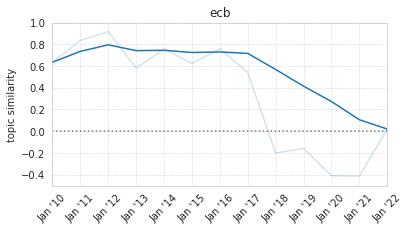

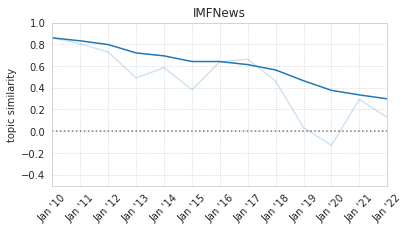

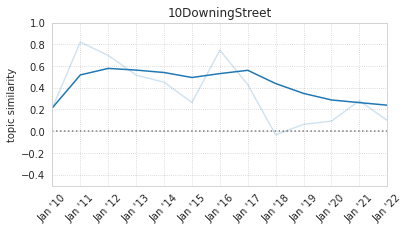

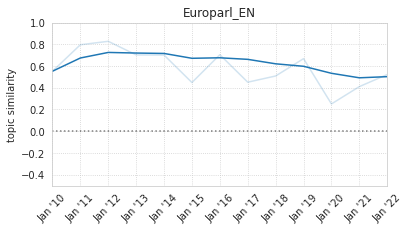

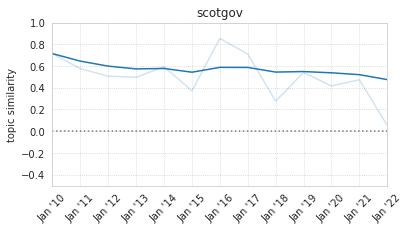

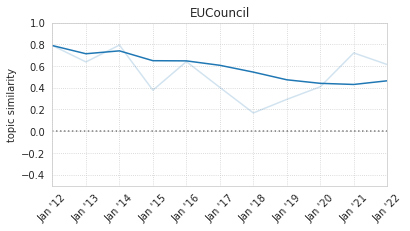

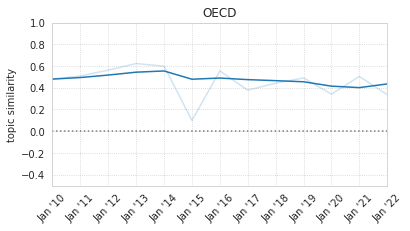

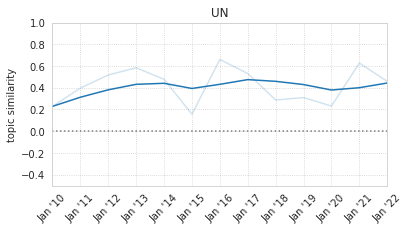

In [33]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

for entity in ['UN', 'OECD', 'EUCouncil', 'scotgov', 'Europarl_EN', 
               '10DowningStreet', 'IMFNews', 'ecb'][::-1]:
    fig, ax = plt.subplots(figsize=(6,3))
    plt.title(f'{entity}')
    edf = cor_df[cor_df['entity']==entity]
    edf['cor_smoothed'] = edf.sort_values(by='date_mapped').cor.rolling(7, 
                                                                        min_periods=1).mean()
    sns.lineplot(data=edf, x='date_mapped', y='cor_smoothed')
    sns.lineplot(data=edf, x='date_mapped', y='cor', 
                 alpha=.2, color=sns.color_palette()[0])
    plt.xticks(ticks=[v for k,v in dct.items() if 'Jan' in k], 
               labels=[k for k,v in dct.items() if 'Jan' in k], 
               rotation=45)
    plt.axhline(0, color='black', alpha=.5, linestyle='dotted')
    plt.ylabel('topic similarity')
    plt.xlim((edf['date_mapped'].dropna().min(), edf['date_mapped'].dropna().max()))
    plt.ylim(-.5,1)
    plt.xlabel('')
    sns.despine(left=False, right=False, top=False)
    plt.show()

For absolute similarity with other agencies, see `Analysis.ipynb` notebook.

### Engagement ~ Volume

In [37]:

eng = preds.groupby(['entity', 
                     'year', 'month', 
                     'top_topic']).sum_count.agg(['count', 'median'])
eng = eng.reset_index()
eng = eng.replace(mapping).replace(old_to_new)
eng['date'] = pd.to_datetime(eng[['year', 'month']].assign(day=1)).dt.strftime('%b \'%y')
vals = pd.to_datetime(eng[['year', 'month']].assign(day=1)).sort_values().dt.strftime('%b \'%y').unique() # , 'month'
dct = dict(zip(vals, range(vals.shape[0])))
eng['date_mapped'] = eng['date'].replace(dct)

In [74]:
sub[sub['date']==vals[i]]

,entity,year,month,top_topic,count,median,date,date_mapped
17548,scotgov,2022,5,Humanitarian support (general),3,11.0,May '22,160
17549,scotgov,2022,5,Health,12,38.0,May '22,160
17550,scotgov,2022,5,Humanitarian support (financial),4,13.0,May '22,160
17551,scotgov,2022,5,Human rights,33,50.0,May '22,160
17552,scotgov,2022,5,Growth and Global Development,4,34.0,May '22,160
17553,scotgov,2022,5,Citizen engagement,1,106.0,May '22,160
17554,scotgov,2022,5,Press conferences and statements,1,29.0,May '22,160
17555,scotgov,2022,5,"Charts, links, infographics",6,42.5,May '22,160
17556,scotgov,2022,5,Strategic investments,3,28.0,May '22,160
17557,scotgov,2022,5,Energy and sustainability,2,43.0,May '22,160


In [131]:
topics = eng.top_topic.unique()
ranks = []
for e in eng.entity.unique():
    ent_sub = eng[eng['entity']==e]
    for i in range(len(vals)-1):
        
        sub = ent_sub[ent_sub['date']==vals[i]]
        
        if sub.shape[0]>0:
            sub = sub.sort_values(by='median', ascending=False)
            sub_count = ent_sub[ent_sub['date']==vals[i+1]]
            if sub_count.shape[0]>0:
                sub_count = sub_count.sort_values(by='count', ascending=False)
                for t in topics:
                    idx = [i for i,tp in enumerate(sub.top_topic) if tp == t]
                    if len(idx) > 0:
                        idx = idx[0]
                    else:
                        idx = np.nan
                    idx_count = [i for i,tp in enumerate(sub_count.top_topic) if tp == t]
                    if len(idx_count) > 0:
                        idx_count = idx_count[0]
                    else:
                        idx_count = np.nan
                    ranks.append((e, vals[i+1], t, idx, idx_count))

In [136]:
rank_df = pd.DataFrame(ranks, columns=['entity', 'date', 'topic', 'rank_engagement', 'rank_nr']).dropna()

In [141]:
sub

,entity,date,topic,rank_engagement,rank_nr
321,10DowningStreet,Oct '10,Growth and Global Development,0.0,3.0


In [142]:
from scipy.stats import pearsonr

cors = []
for e in rank_df.entity.unique():
    ent_sub = rank_df[rank_df['entity']==e]
    for i in range(len(vals)-1):
        sub = ent_sub[ent_sub['date']==vals[i+1]]
        if sub.shape[0] > 1:
            c =  pearsonr(sub.rank_nr.tolist(),
                          sub.rank_engagement.tolist())[0] # .correlation
            cors.append((e, vals[i+1], c))

In [ ]:
# pd.DataFrame(cors, columns=['entity', 'month','value']).replace(dct)

In [165]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

cordata = pd.DataFrame(cors, columns=['entity', 'month','value']).replace(dct)
for e in rank_df.entity.unique():
    sub = cordata[cordata['entity']==e].sort_values(by='month')
    mod = smf.ols(formula='value ~ month', data=sub)
    res = mod.fit()
    print(e, round(res.params[1],3), round(res.pvalues[1],3)) 
    # print(e, round(pearsonr(sub.month.tolist(), sub.value.tolist())[0],3))

10DowningStreet -0.0 0.583
EUCouncil 0.001 0.484
EU_Commission 0.004 0.0
Europarl_EN 0.002 0.001
IMFNews 0.001 0.175
OECD -0.0 0.939
UN 0.002 0.009
ecb -0.002 0.001
scotgov 0.001 0.533


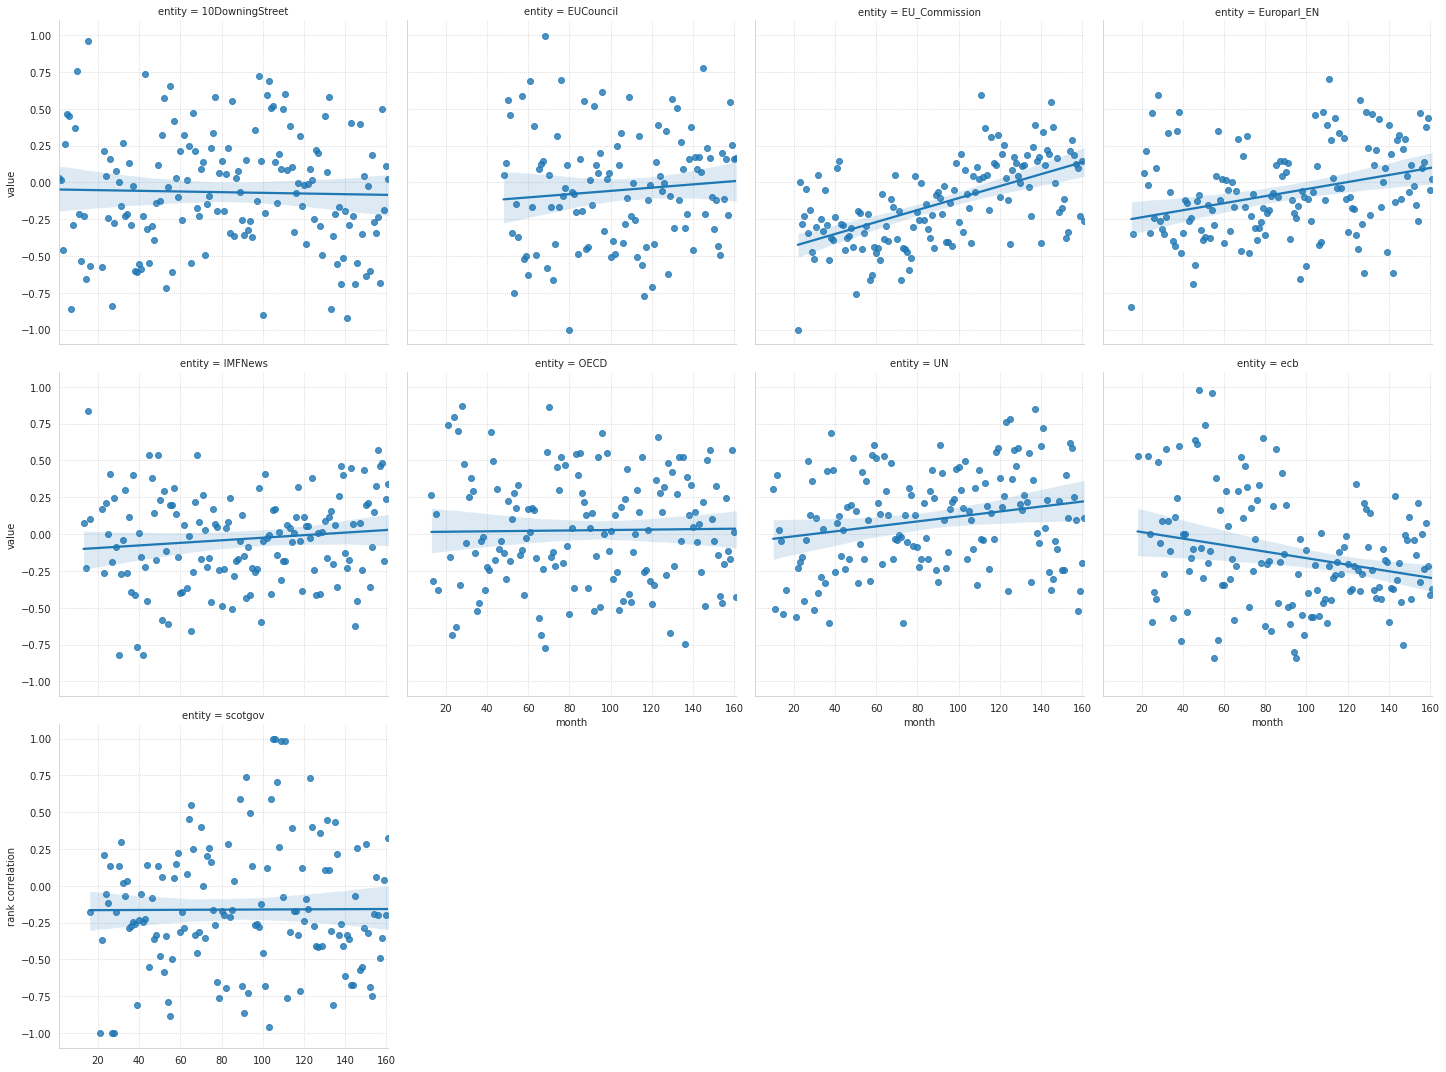

In [146]:
sns.lmplot(data=cordata, 
            x='month', y='value', col='entity', col_wrap=4, robust=True)
plt.ylabel('rank correlation')
plt.xlabel('')
#plt.xticks(ticks=np.arange(3,143,12),
#           labels=[f'20{inv_dct[k][5:]}' for k in np.arange(3,143,12)],
#           rotation=45)
plt.show()

Increasingly better at responding to user engagement.

In [1200]:
counts = rank_df.groupby(['topic']).rank_engagement.mean().reset_index().sort_values(by='rank_engagement')

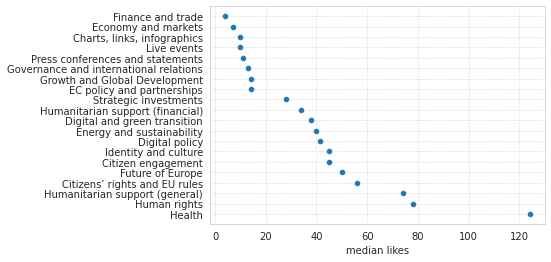

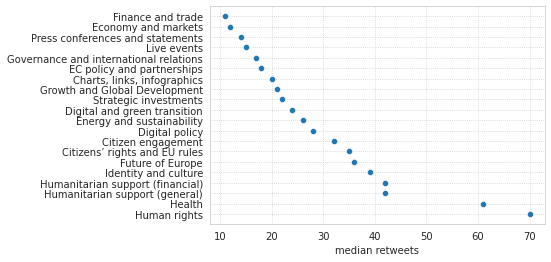

In [167]:
for m in ['like_count', 'retweet_count']:
    sns.scatterplot(data=preds[preds['entity']=='EU_Commission'].replace(mapping).replace(old_to_new).groupby('top_topic')[m].median().reset_index().sort_values(by=m), 
                    y='top_topic', x=m)
    plt.xlabel(f'median {m.split("_")[0]}s')
    plt.ylabel('')
    plt.show()

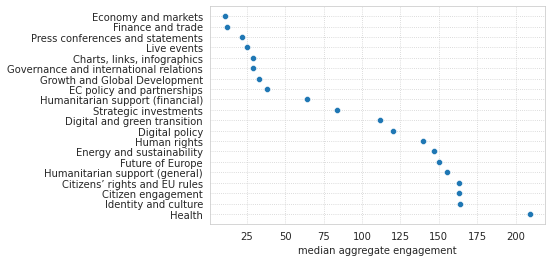

In [172]:
for m in ['sum_count']:
    sns.scatterplot(data=preds[preds['entity']=='EU_Commission'].replace(mapping).replace(old_to_new).groupby('top_topic')[m].median().reset_index().sort_values(by=m), 
                    y='top_topic', x=m)
    plt.xlabel(f'median aggregate engagement')
    plt.ylabel('')
    plt.show()

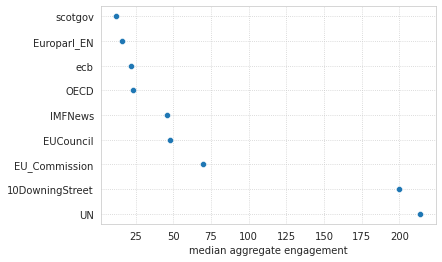

In [185]:
sns.scatterplot(data=preds.replace(mapping).replace(old_to_new).groupby(['entity'])['sum_count'].median().reset_index().sort_values(by='sum_count'), 
                x='sum_count', y='entity')
plt.xlabel(f'median aggregate engagement')
plt.ylabel('')
plt.show()

In [188]:
# dta = preds.replace(mapping).replace(old_to_new)
dta['date'] = dta['year'].astype(str) + '_' + dta['month'].astype(str)

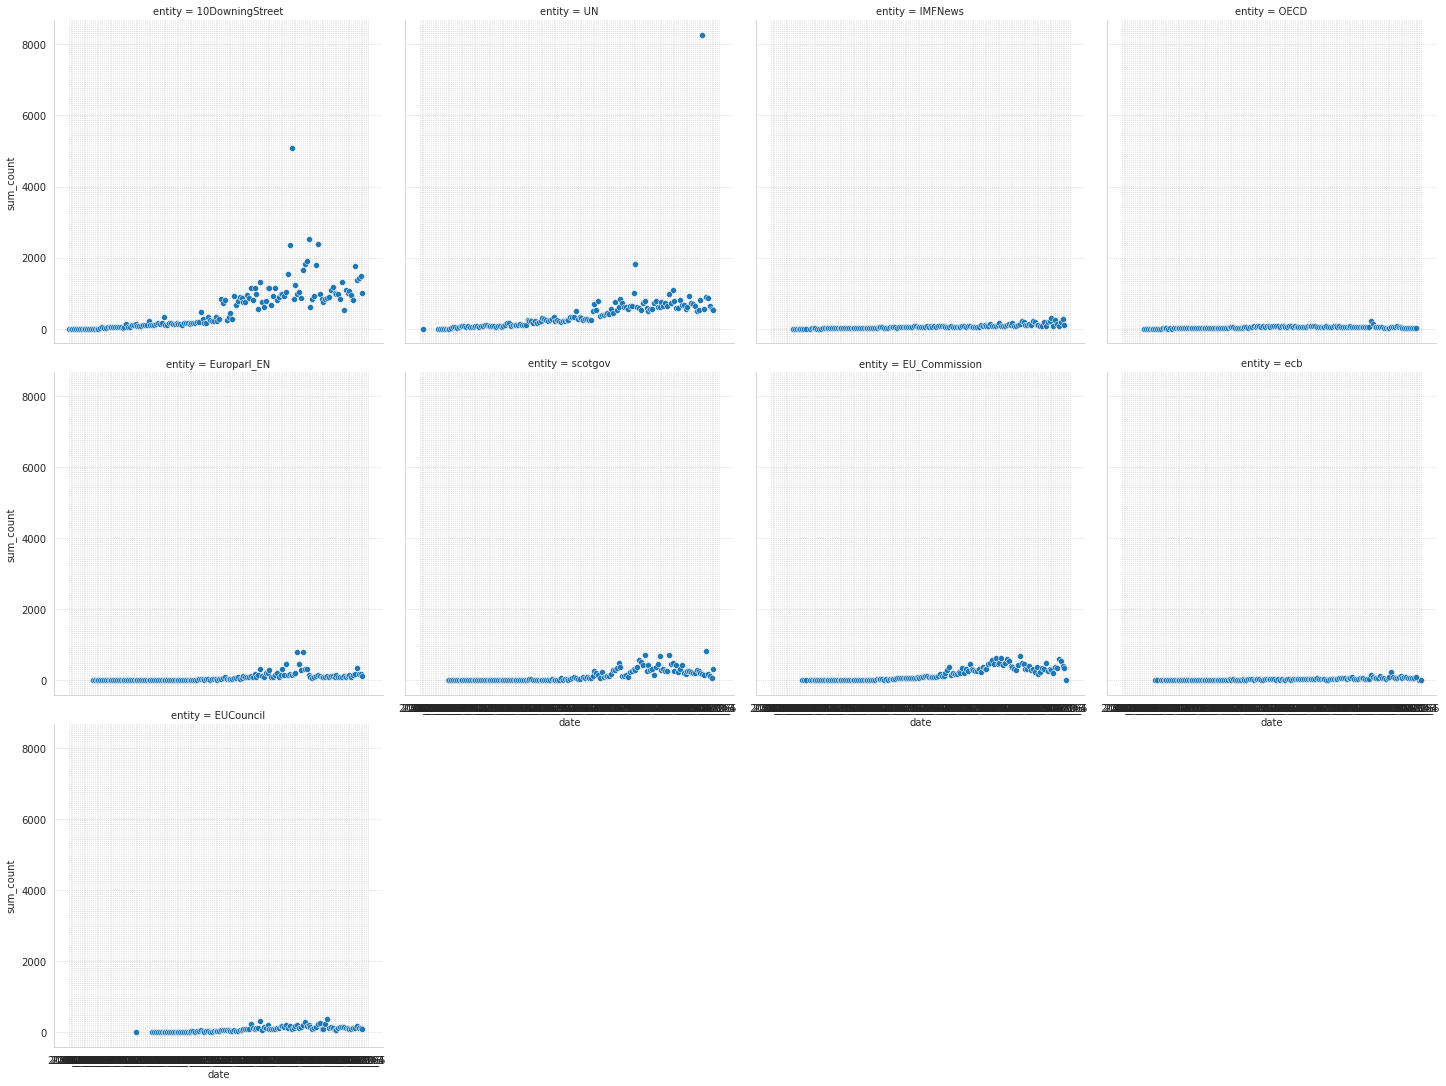

In [194]:
# TODO: turn this into proper plots
sns.relplot(data=dta.groupby(['date','entity'])['sum_count'].mean().reset_index(), 
            x='date', y='sum_count', col='entity', col_wrap=4)
##plt.xlabel(f'median aggregate engagement')
##plt.xticks(rotation=90)
#plt.ylabel('')
plt.show()

In [186]:
preds

,index,text,lang,id,like_count,quote_count,reply_count,retweet_count,created_at,is_retweet,...,top_rev,Economy and Finance,Policy and integration,Identity and Culture,Governance and partnerships,Humanitarian,Miscellaneous,year,month,day
0,0,First Minister @NicolaSturgeon will deliver a ...,en,1250818275199651840,270,9,31,109,2020-04-16,0,...,-0.0023,0.006800,0.01922,0.012633,0.00685,0.005100,0.269933,2020,4,16
1,1,Update on #coronavirus testing\n\nAs of 2pm to...,en,1250770976532508672,119,8,26,109,2020-04-16,0,...,-0.0147,0.017125,0.11334,0.020600,0.02165,0.043000,0.043500,2020,4,16
2,2,Scotland’s Makar @JackieKayPoet has written a ...,en,1250725095926124544,583,90,21,326,2020-04-16,0,...,0.0501,0.029450,0.05984,0.036867,0.01795,0.078500,0.067067,2020,4,16
3,3,While our primary concern is for people’s heal...,en,1250487804963979264,187,7,24,100,2020-04-15,0,...,0.1054,0.021725,0.06450,0.009067,0.00900,0.170633,0.011200,2020,4,15
4,4,"In a move agreed by @ScotGov and @COSLA, socia...",en,1250427438279979008,377,11,18,146,2020-04-15,0,...,0.0599,0.086900,0.05684,0.015367,0.02170,0.060633,0.032300,2020,4,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167969,169680,David Cameron will deliver a speech this morni...,en,103022959018524672,2,0,42,58,2011-08-15,0,...,0.0122,0.026550,0.03438,0.142733,0.02935,0.031100,0.047300,2011,8,15
167970,169681,"The PM and President Obama discuss Syria, Liby...",en,102460308576149504,5,0,47,33,2011-08-13,0,...,0.0045,0.011650,0.00762,0.013633,0.19970,0.012667,0.145733,2011,8,13
167971,169683,David Cameron meets organisers and participant...,en,101970042769518592,3,0,35,43,2011-08-12,0,...,0.0030,0.021600,0.01168,0.130600,0.03460,0.019400,0.111933,2011,8,12
167972,169684,Read David Cameron's statement to Parliament o...,en,101608394682671105,9,0,70,112,2011-08-11,0,...,0.0081,0.029475,0.01386,0.025667,0.02125,0.020633,0.210500,2011,8,11
